In [1]:
import numpy as np
import numpy.random as rand
import matplotlib as mpl
from matplotlib import pyplot as mp, patches, widgets
import cv2 as cv
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# mpl.use('nbagg')
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
def otsu(image):
    image = (image/image.max() * 255).astype('uint8')
    hist = np.squeeze(cv.calcHist([image], [0], None, [256], [0, 255]))
    total = image.size
    top = 256
    sumB = 0
    wB = 0
    maximum = 0.0
    sum1 = np.arange(top) @ hist
    for i in range(top):
        wF = total - wB
        if wB > 0 and wF > 0:
            mF = (sum1 - sumB) / wF
            val = wB * wF * ((sumB/wB) - mF)**2
            if val >= maximum:
                level = i
                maximum = val
        wB += hist[i]
        sumB += i * hist[i]
    return level

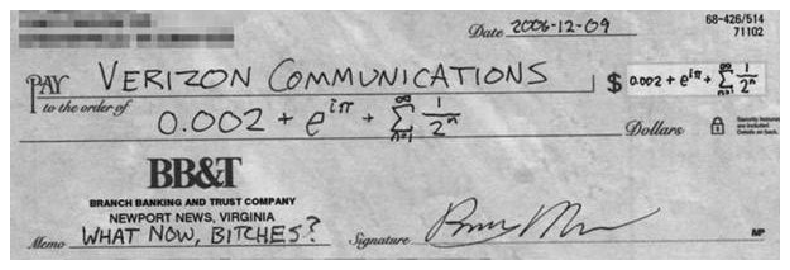

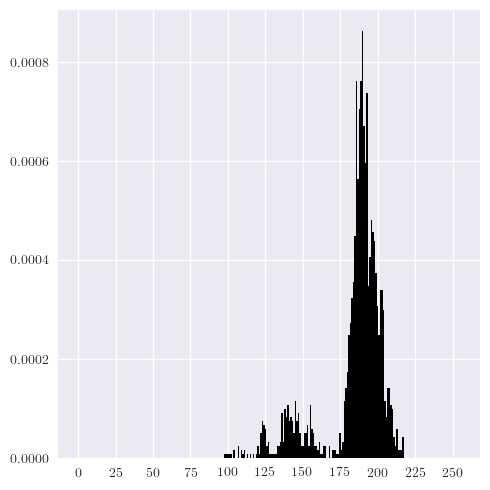

In [15]:
cheq = cv.imread('grayscale_check.jpg')
hist = np.zeros(256)
for i in range(cheq.shape[-1]):
    hist += np.squeeze(cv.calcHist(cheq, [i], None, [256], [0, 255]))
hist /= cheq.size

mp.imshow(cheq, 'gray')
mp.axis('off')
mp.tight_layout()
mp.show()

fig = mp.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.bar(range(256), hist, color='k', width=1.0)
ax.xaxis.set_major_locator(mp.MultipleLocator(25))
# mp.savefig('check_hist.png', dpi=300, bbox_inches='tight')
mp.tight_layout()
mp.show()

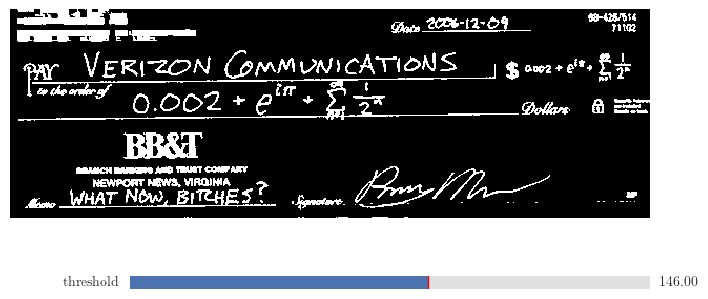

In [6]:
cgray = cv.cvtColor(cheq, cv.COLOR_BGR2GRAY)

fig, ax = mp.subplots()
mp.subplots_adjust(left=0.1, bottom=0.1)
ax.axis('off')
ax.grid(0)
Int = np.arange(256)
I0 = otsu(cgray)
delta_I = 1
BW = cgray < I0
im = mp.imshow(BW, 'gray')
ax.margins(x=0)

axthres = mp.axes([0.25, 0.1, 0.65, 0.03], facecolor='#e0e0e0')
sthres = widgets.Slider(axthres, 'threshold', 0, 255, valinit=I0, valstep=delta_I)

def update(val):
    thres = sthres.val
    im.set_array(cgray < thres)
    fig.canvas.draw_idle()
    
sthres.on_changed(update)

# mp.tight_layout()
mp.show()

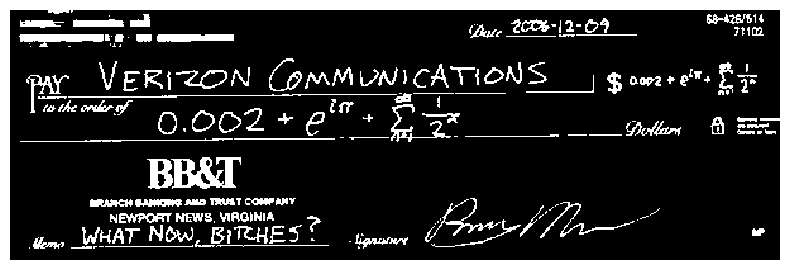

In [17]:
cheq = cv.imread('grayscale_check.jpg', 0)
hist = np.squeeze(cv.calcHist(cheq, [0], None, [256], [0, 255]))/cheq.size

mp.imshow(cheq < 125, 'gray')
mp.axis('off')
mp.tight_layout()
# mp.savefig('check_thres125.png', dpi=300, bbox_inches='tight')
mp.show()

146


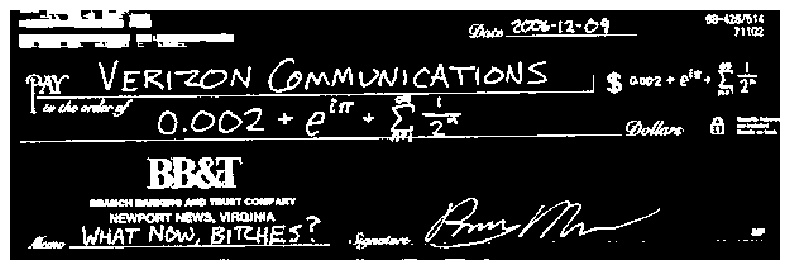

In [19]:
otsu_thres = otsu(cheq)
print(otsu_thres)

mp.imshow(cheq < otsu_thres, 'gray')
mp.axis('off')
mp.tight_layout()
# mp.savefig('check_otsu.png', dpi=300, bbox_inches='tight')
mp.show()

In [8]:
class ImageSegment:
    
    def __init__(self, image):
        if type(image) == str:
            self.image = cv.imread(image)
        elif type(image) == np.ndarray:
            self.image = image
        else:
            raise NotImplementedError
        self.image_hist = np.squeeze(cv.calcHist([self.image.ravel()], [0], None, [256], [0, 255]))
        eps = 1e-4
#         self.image[np.where(-eps < self.image.all() < eps)[0]] = 1e5
        self.cropping = False
        self.sel_rect_endpoint = None
        self.refpt = None
        
    def BGR2NCC(self, img):
        I = img.sum(axis=2)
        b, g, r = cv.split(img)/I
        return I, r, g

    def pixelLikelihood(self, r, mu, sigma):
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2 * sigma**2))
    
    def ColorPicker(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.refpt = [(x, y)]
            self.cropping = True
            
        elif event == cv.EVENT_LBUTTONUP:
            self.refpt.append((x, y))
            self.cropping = False

            cv.rectangle(self.image, self.refpt[0], self.refpt[1], (0, 255, 0), 2)
            cv.imshow('macbeth', self.image)
            
        elif event == cv.EVENT_MOUSEMOVE and self.cropping:
            self.sel_rect_endpoint = [(x, y)]
            
    def get_ROI(self):
        image = (self.image/self.image.max()).astype('float32')
        clone = image.copy()
        cv.namedWindow('macbeth', cv.WINDOW_NORMAL)
        if image.shape[0] > image.shape[1]:
            cv.resizeWindow('macbeth', 400, 600)
        else:
            cv.resizeWindow('macbeth', 600, 400)
        cv.setMouseCallback('macbeth', self.ColorPicker)

        while True:
            if not self.cropping:
                cv.imshow('macbeth', self.image)
            elif self.cropping and self.sel_rect_endpoint:
                rect_cpy = image.copy()
                cv.rectangle(rect_cpy, self.refpt[0], self.sel_rect_endpoint[0], (0, 255, 0), 1)
                cv.imshow('macbeth', rect_cpy)
            
            key = cv.waitKey(1) & 0xFF
            if key == ord('r'):
                image = clone.copy()

            elif key == ord('c'):
                break

        if len(self.refpt) == 2:
            self.roi = clone[self.refpt[0][1]:self.refpt[1][1], self.refpt[0][0]:self.refpt[1][0]]
            cv.imshow("ROI", self.roi)
            cv.waitKey(0)

        cv.destroyAllWindows()
    
    def get_chromaROI(self):
        I, r, g = self.BGR2NCC(self.roi)
        self.mu_r, self.sigma_r = np.mean(r), np.std(r)
        self.mu_g, self.sigma_g = np.mean(g), np.std(g)
        
    def get_chromaIMG(self):
        image = (self.image/self.image.max()).astype('float32')
        I, r, g = self.BGR2NCC(image)
        pr = self.pixelLikelihood(r, self.mu_r, self.sigma_r)
        pg = self.pixelLikelihood(g, self.mu_g, self.sigma_g)
        self.combinedHist = pr * pg
        self.param_out = self.combinedHist.copy()
        
    def get_histROI(self, bins=32, plot_hist=False):
        I, r, g = self.BGR2NCC(self.roi)
        rint = (r*(bins-1)).astype('uint8')
        gint = (g*(bins-1)).astype('uint8')
        rg = np.dstack((rint, gint))
        hist = cv.calcHist([rg], [0, 1], None, [bins, bins], [0, bins-1, 0, bins-1])
        if plot_hist:
            mp.figure(figsize=(5, 5))
            cl_hist = np.clip(hist, 0, bins-1)
            mp.imshow(cl_hist, 'gray', origin='lower')
            mp.xlabel('$g$')
            mp.ylabel('$r$')
            mp.grid(0)
            mp.show()
        self.histROI = hist
        self.bins = bins
        
    def get_histIMG(self):
        bins = self.bins
        I, r, g = self.BGR2NCC(self.image)
        rproj = (r*(bins-1)).astype('uint8')
        gproj = (g*(bins-1)).astype('uint8')
        proj_array = np.zeros(r.shape)
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):
                proj_array[i,j] = self.histROI[rproj[i,j], gproj[i,j]]
        self.combinedHist = proj_array
        self.nparam_out = self.combinedHist.copy()
    
    def plot_segment(self):
        fig = mp.figure(figsize=(16, 9))
        
        ax = fig.add_subplot(121)
        ax.imshow(self.image[:,:,::-1])
        ax.axis('off')
        ax.grid(0)
        
        ax = fig.add_subplot(122)
        ax.imshow(self.combinedHist, 'gray')
        ax.axis('off')
        ax.grid(0)

        mp.show()
        
    def parametric(self, **kwargs):
        self.get_ROI()
        self.get_chromaROI()
        self.get_chromaIMG()
#         self.plot_segment()
        
    def nonparametric(self, **kwargs):
        if self.refpt is None:
            self.get_ROI()
        self.get_histROI(**kwargs)
        self.get_histIMG()
#         self.plot_segment()

    def otsu(self):
        image = self.image.copy()
        image = (image/image.max() * 255).astype('uint8')
        hist = np.squeeze(cv.calcHist([image], [0], None, [256], [0, 255]))
        total = image.size
        top = 256
        sumB = 0
        wB = 0
        maximum = 0.0
        sum1 = np.arange(top) @ hist
        for i in range(top):
            wF = total - wB
            if wB > 0 and wF > 0:
                mF = (sum1 - sumB) / wF
                val = wB * wF * ((sumB/wB) - mF)**2
                if val >= maximum:
                    level = i
                    maximum = val
            wB += hist[i]
            sumB += i * hist[i]
        self.level = level
        
    def main(self, savename=None, **kwargs):
        self.parametric(**kwargs)
        self.nonparametric(**kwargs)
        if self.image.shape[0] > self.image.shape[1]:
            fig = mp.figure(figsize=(16/2, 9/2))
        else:
            fig = mp.figure(figsize=(16/2*2, 9/2))
        
        ax = fig.add_subplot(131)
        ax.imshow(self.image[:,:,::-1])
        ax.axis('off')
        ax.grid(0)
        ax.set_title('original')
        
        ax = fig.add_subplot(132)
        ax.imshow(self.param_out, 'gray')
        ax.axis('off')
        ax.grid(0)
        ax.set_title('parametric')
        
        ax = fig.add_subplot(133)
        ax.imshow(self.nparam_out, 'gray')
        ax.axis('off')
        ax.grid(0)
        ax.set_title('non-parametric')
        
        mp.tight_layout()
        if savename is not None:
            mp.savefig(savename, dpi=300, bbox_inches='tight')
        mp.show()

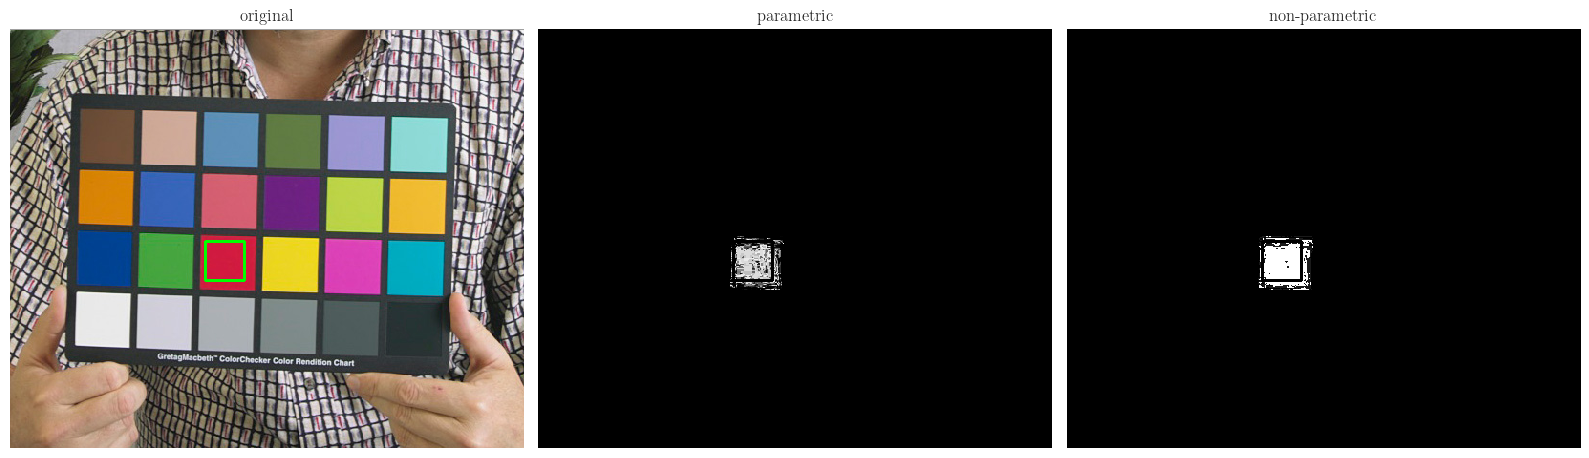

In [32]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.main('mac_red_out.png')

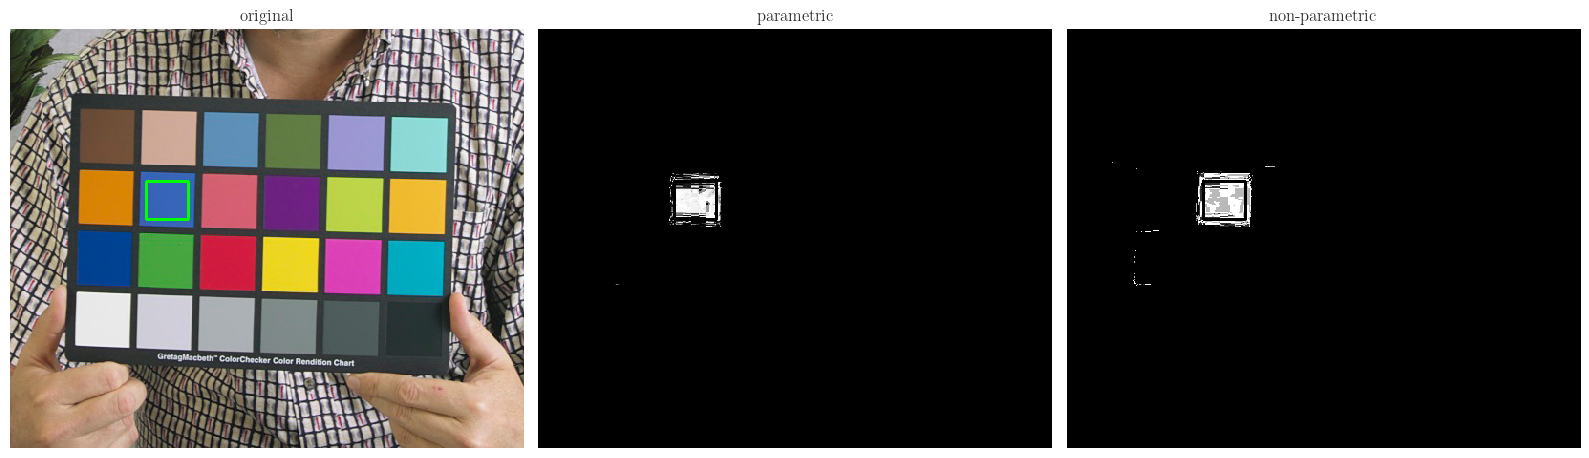

In [42]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.main('mac_blue_out.png')

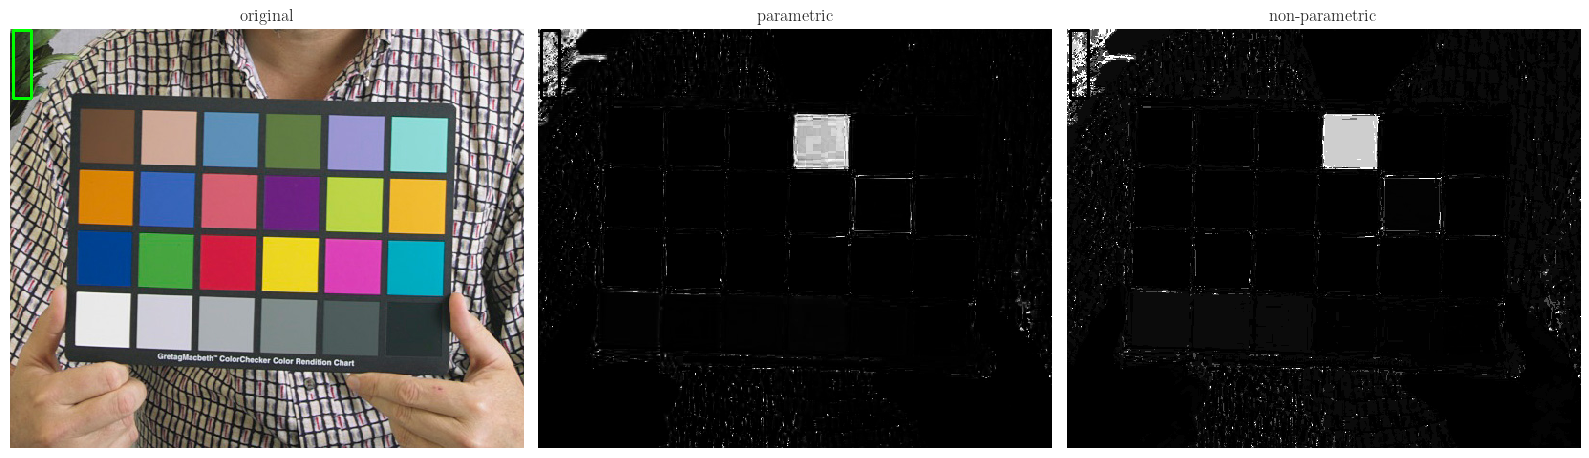

In [43]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.main('mac_green_out.png')

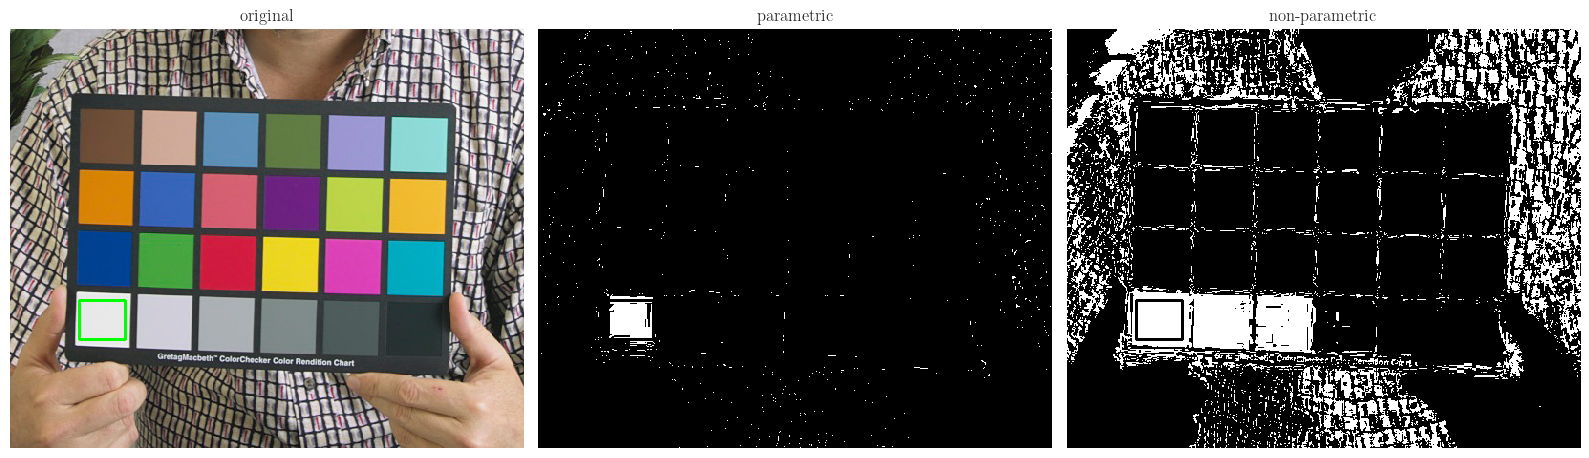

In [44]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.main('mac_white_out.png')

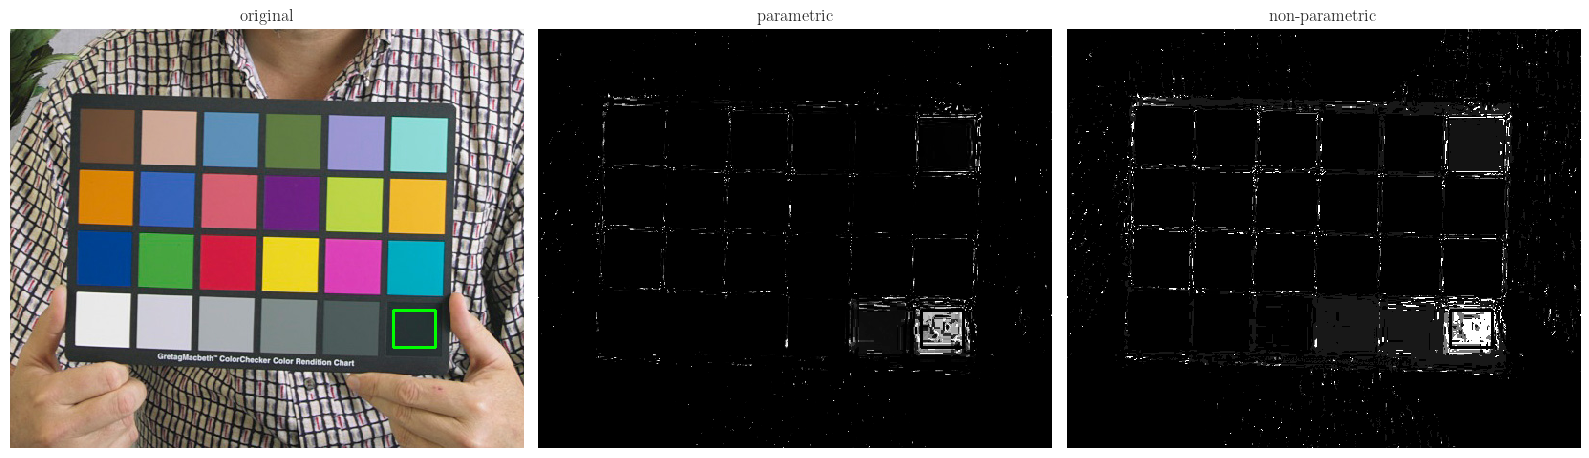

In [45]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.main('mac_black_out.png')

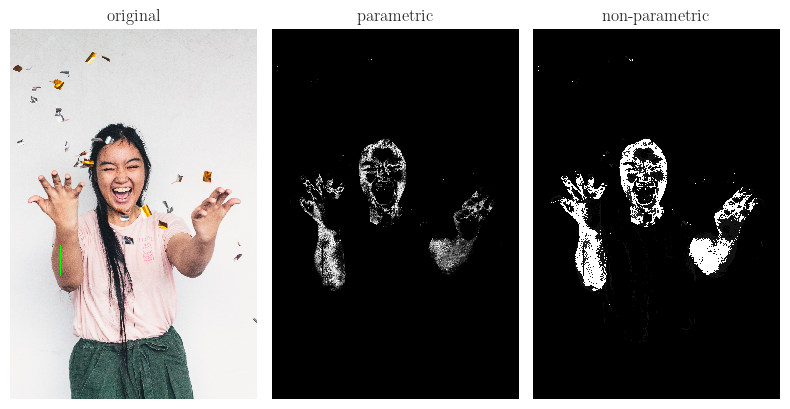

In [40]:
seg = ImageSegment('IMG_9539.JPG')
seg.main('jena_arm_out.png')

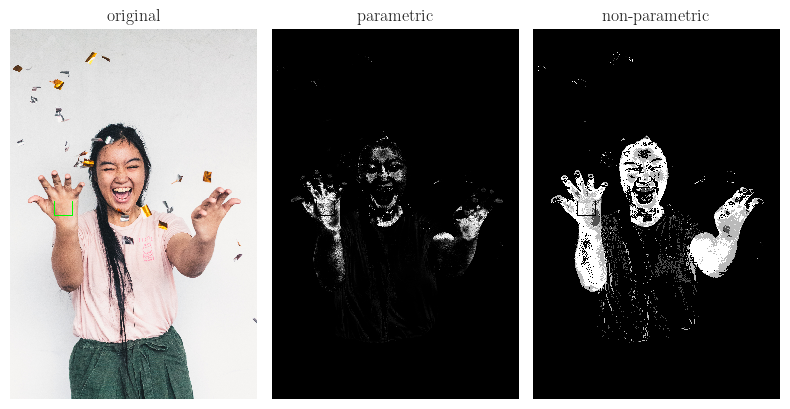

In [6]:
seg = ImageSegment('IMG_9539.JPG')
seg.main('jena_hand_out.png')

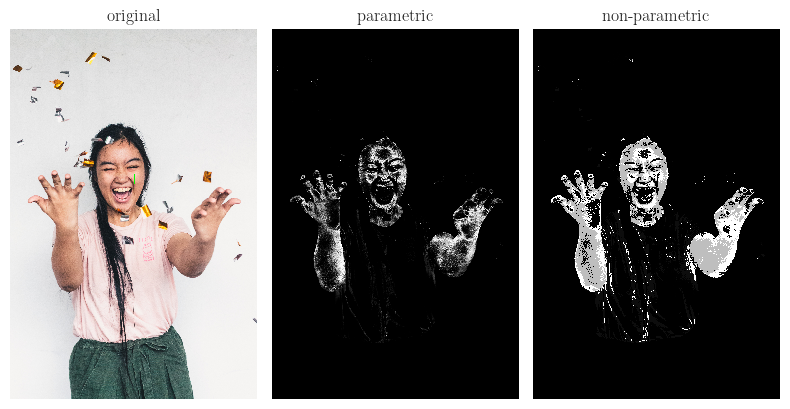

In [7]:
seg = ImageSegment('IMG_9539.JPG')
seg.main('jena_cheek_out.png')

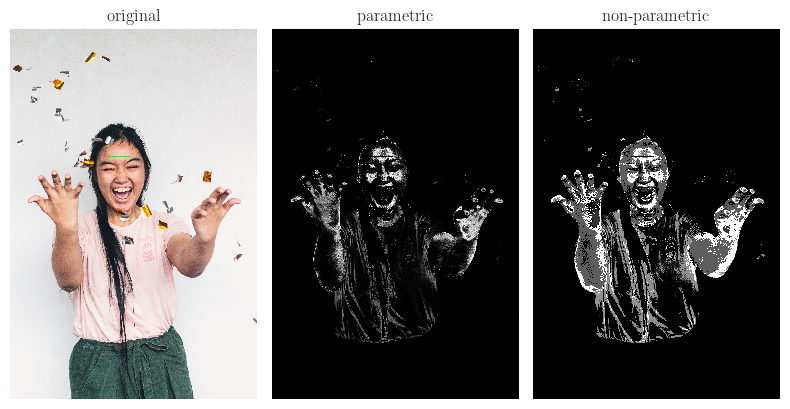

In [8]:
seg = ImageSegment('IMG_9539.JPG')
seg.main('jena_forehead_out.png')

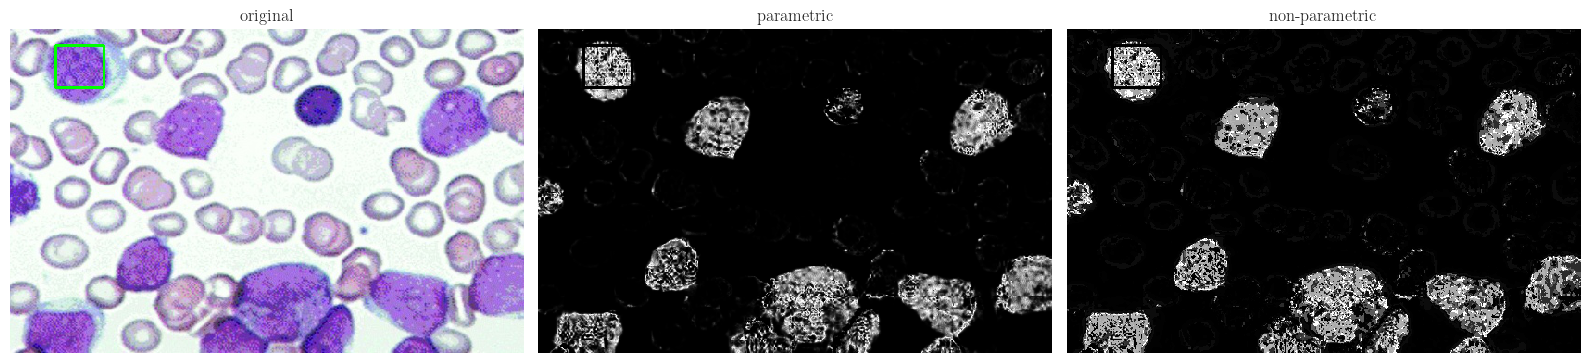

In [23]:
seg = ImageSegment('cancer.jpg')
seg.main('cancer_giemsa.png')

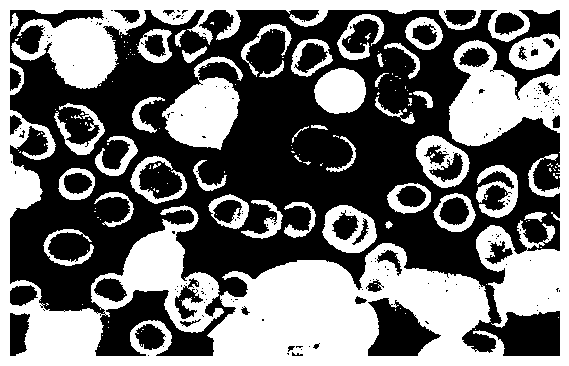

In [30]:
img = cv.imread('cancer.jpg', 0)
seg = ImageSegment(img)
seg.otsu()
mp.imshow(img < seg.level, 'gray')
mp.grid(0)
mp.axis('off')
# mp.savefig('cancer_otsu.png', dpi=300, bbox_inches='tight')
mp.show()